# Generating trajectories using quantum state diffusion.

The purpose of this notebook is to generate data that could be analyzed using machine learning algorithms. I use quantum state diffusion (as opposed to quantum jump trajectories) to investigate how the dynamics and geometry might be different. The files are saved in the same format as the notebooks my other repo, diffusion_maps: https://github.com/tabakg/diffusion_maps

1. Kerr in qubit regime
2. Kerr in bistable regime
3. Atom bistability (see notebook "make_quantum_trajectories-absorptive_bistability").

We will also be interested in the transition between the first and second regimes of the Kerr system.
I store trajectory files as .pkl files or .mat files. This way I can easily load them into another notebook, or load the trajectories to matlab.

In [1]:
## Some of the code seems to require Python 3

import sys
sys.version

import os
directory_name = "/trajectory_data"
d = (os.getcwd() + directory_name)
try:
    os.stat(d)
except:
    os.mkdir(d)
    
####
####

### Select Regime from "kerr_qubit", "kerr_bistable", "intermediate_state"
### TODO: implement a regime "transition_kerr" which increases the drive periodically, or stochastically, etc.

####

### Which file formats to save trajectory data.
### Name of the file to save. The extension will be .mat for matlab and .pkl for pickle.

## matlab file.
save_mat = True

## pkl file (can be loaded in python) in the same format as above.
save_pkl = True

####
####

import matplotlib as mil
mil.use('TkAgg')

## QHDL package
from qnet.algebra.circuit_algebra import *
from qnet.circuit_components.displace_cc import Displace
from sympy import sqrt

## SDE integrator
import sdeint

## quantum state diffusion solver
from quantum_state_diffusion import qsd_solve
from quantum_state_diffusion import qsd_solve_two_systems

## numerical libraries
import numpy as np
import numpy.linalg as la
from scipy import sparse

## plottinsg
import matplotlib.pyplot as plt

## pickle
import pickle

from save2matfile_or_pkl import save2matfile_or_pkl

%matplotlib inline


# Kerr Bistable Regime

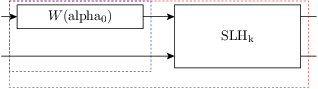

In [2]:
Regime = "kerr_bistable"
file_name = '.' + directory_name + '/QSD_' + Regime

# Define Kerr parameters
chi = symbols("chi", real=True, positive=True)
Delta = symbols("Delta", real=True)
kappa_1, kappa_2 = symbols("kappa_1, kappa_2", real=True, positive=True)
alpha0 = symbols("alpha_0")
    
params = {alpha0 : 21.75, chi : -10, Delta : 100., kappa_1 : 25, kappa_2 : 25,
              'Ntraj' : 50, 'duration' : .3, 'Nfock' : 50, 'delta_t': 1e-5, 'downsample': 100}
    
## These are used later in the simulation
ntraj = params['Ntraj']
duration = params['duration']
Nfock = params['Nfock']
delta_t = params['delta_t']
downsample = params['downsample']

# Construct Kerr SLH
a_k = Destroy("k")
S = -identity_matrix(2)
L = [sqrt(kappa_1)*a_k, sqrt(kappa_2)*a_k]
H = Delta*a_k.dag()*a_k + chi/2*a_k.dag()*a_k.dag()*a_k*a_k
KERR = SLH(S, L, H).toSLH()

# Add coherent drive
SYS = KERR << Displace(alpha=alpha0)+cid(1)
SYS.show()
SYS = SYS.toSLH()

SYS_no_drive = KERR.toSLH()

SYS_num = SYS.substitute(params)
SYS_num_no_drive = SYS_no_drive.substitute(params)

SYS_num.space.dimension = Nfock
SYS_num_no_drive.space.dimension = Nfock
tspan = np.arange(0, duration, delta_t)

H_num, L_num = SYS_num.HL_to_qutip()
H_no_drive_num, L_no_drive_num = SYS_num_no_drive.HL_to_qutip()


## Observables

obs = [a_k.dag()*a_k, a_k+a_k.dag(), (a_k-a_k.dag())/1j]
obsq = [o.to_qutip(full_space = SYS_num.space) for o in obs]

In [3]:
tspan.shape

(30000,)

## master equation

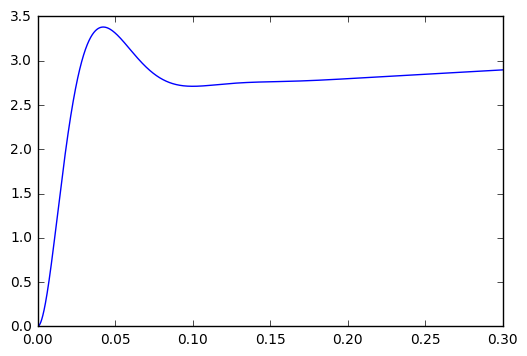

In [9]:
import qutip

psi0 = qutip.basis(Nfock, 0)
me_obs = [a_k.dag()*a_k ]
me_obsq = [o.to_qutip(full_space=SYS.space) for o in me_obs]
me_data = qutip.mesolve(H_num, psi0, tspan, L_num, e_ops=me_obsq)

plt.plot(tspan, me_data.expect[0]);

## Single system SDE

duration = 5.0
Nfock = 30
delta_t = 1e-4

In [4]:
psi0 = sparse.csr_matrix(([1] + [0]*(Nfock-1)),dtype=np.complex128).T
H = H_num.data
Ls = [L.data for L in L_num]
obsq_data = [ob.data for ob in obsq]

In [27]:
seed = [i for i in range(ntraj)]

In [28]:
# H, psi0, tspan, Ls, sdeint.itoSRI2, obsq_data, ntraj

In [29]:
D = qsd_solve(H, psi0, tspan, Ls, sdeint.itoSRI2, obsq = obsq_data,
              ntraj = ntraj, seed = seed, normalize_state = True, normalized_equation=True)

/Users/gil/Google Drive/repos/diffusion_maps/quantum_state_diffusion/quantum_state_diffusion.py:134: RuntimeWarning: overflow encountered in cdouble_scalars
  for L,l,Lpsi in zip(self.Ls, self.ls, self.Lpsis)]))
/Users/gil/Google Drive/repos/diffusion_maps/quantum_state_diffusion/quantum_state_diffusion.py:134: RuntimeWarning: invalid value encountered in cdouble_scalars
  for L,l,Lpsi in zip(self.Ls, self.ls, self.Lpsis)]))
/Users/gil/Google Drive/repos/diffusion_maps/quantum_state_diffusion/quantum_state_diffusion.py:134: RuntimeWarning: overflow encountered in multiply
  for L,l,Lpsi in zip(self.Ls, self.ls, self.Lpsis)]))
/Users/gil/Google Drive/repos/diffusion_maps/quantum_state_diffusion/quantum_state_diffusion.py:134: RuntimeWarning: invalid value encountered in multiply
  for L,l,Lpsi in zip(self.Ls, self.ls, self.Lpsis)]))
/Users/gil/Google Drive/repos/diffusion_maps/quantum_state_diffusion/quantum_state_diffusion.py:150: RuntimeWarning: overflow encountered in multiply
  for 

Run time:   10.376233100891113  seconds.


In [20]:
D['psis'].shape

(50, 3000, 30)

In [21]:
D.update({'tspan':tspan})
D_downsampled = {'psis' : D['psis'][:,::downsample],
                 'obsq_expects' : D['obsq_expects'][:,::downsample], 
                 'seeds' : D['seeds'],
                 'tspan' : D['tspan'] }

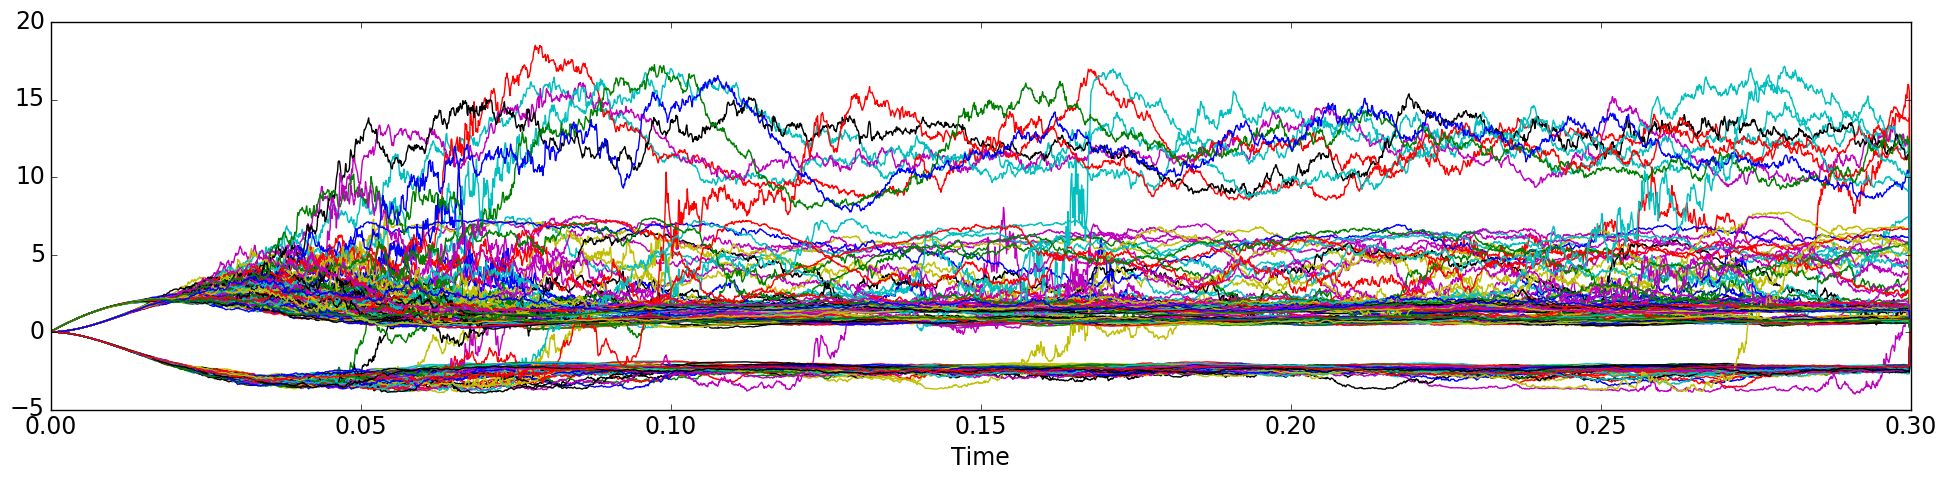

In [22]:
## Plot the observables
f, a = plt.subplots(figsize=(24,5))
plt.xlabel("Time", fontsize=17);# plt.ylabel("Photon Number", fontsize=17)
plt.tick_params(labelsize=17)

for t in range(ntraj):
    for i in range(3):
        plt.plot(tspan,D['obsq_expects'][t,:,i].real)

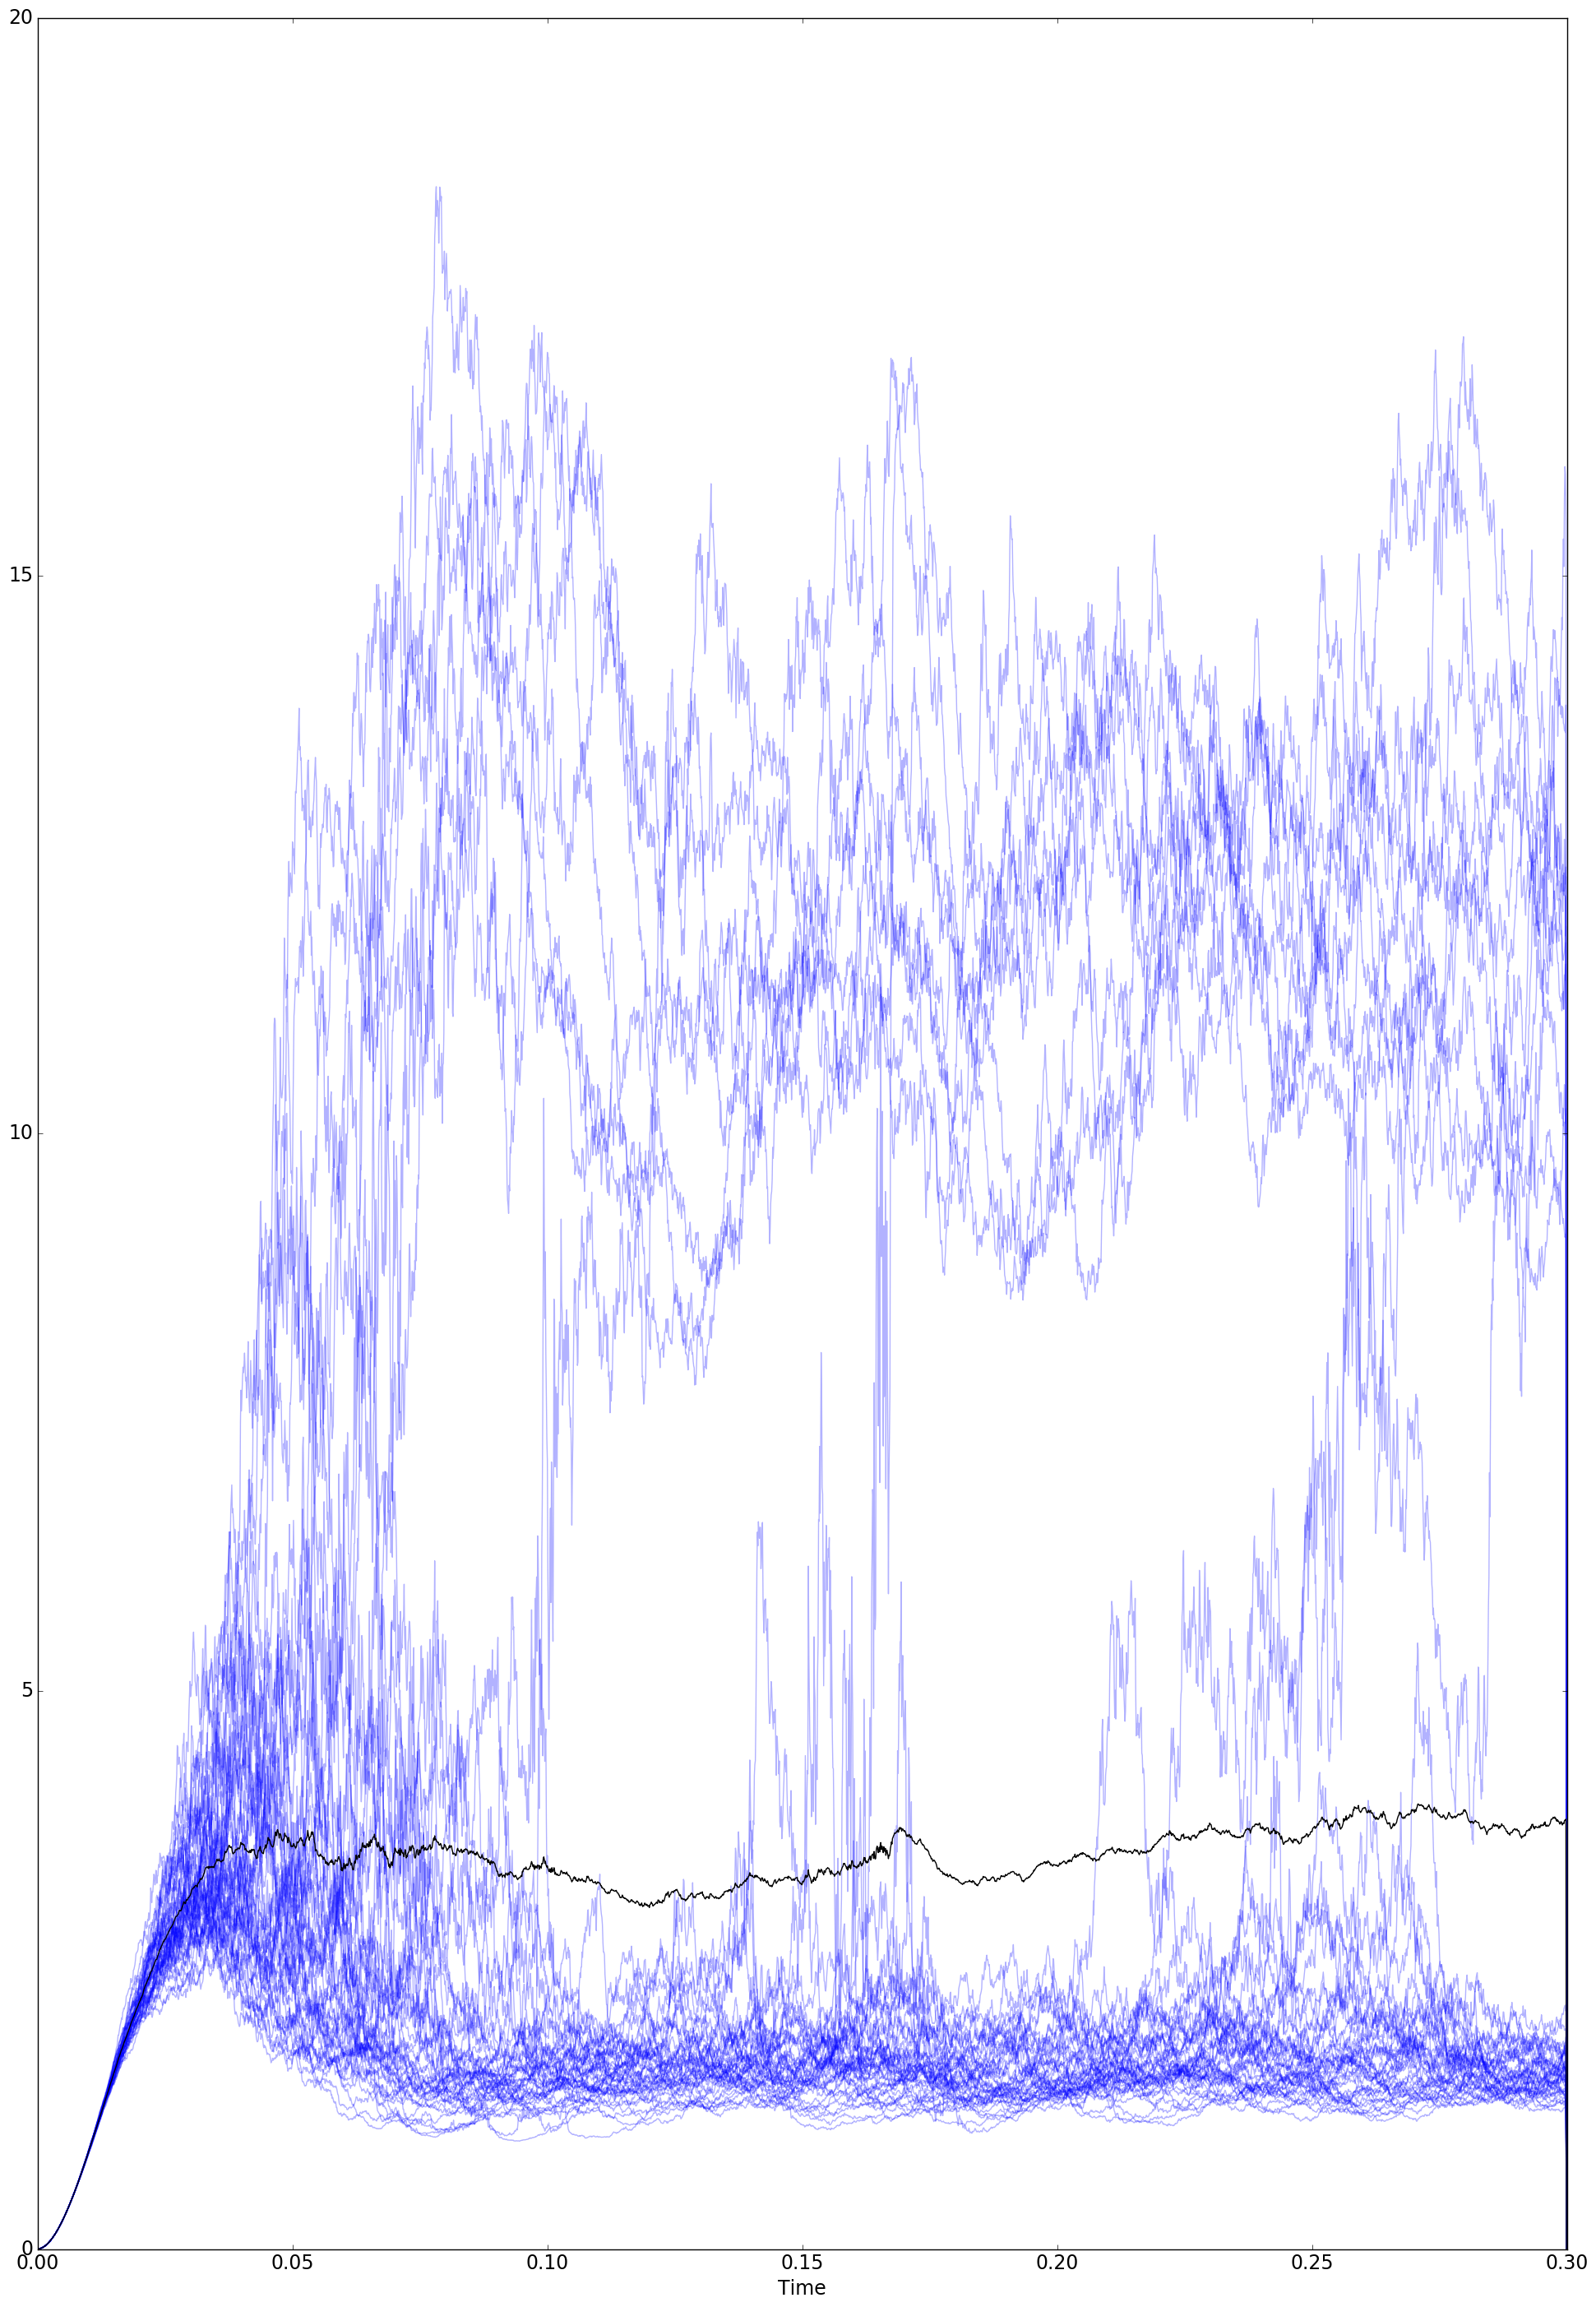

In [23]:
f, a = plt.subplots(figsize=(24,35))
plt.xlabel("Time", fontsize=17);# plt.ylabel("Photon Number", fontsize=17)
plt.tick_params(labelsize=17)


for t in range(ntraj): 
    a.plot( tspan, D['obsq_expects'][t,:,0].real , "b", alpha=0.3)

a.plot(tspan,
       np.average( np.asarray( [D['obsq_expects'][t,:,0].real for t in range(ntraj) ] ), axis = 0),
       c='black',
      )


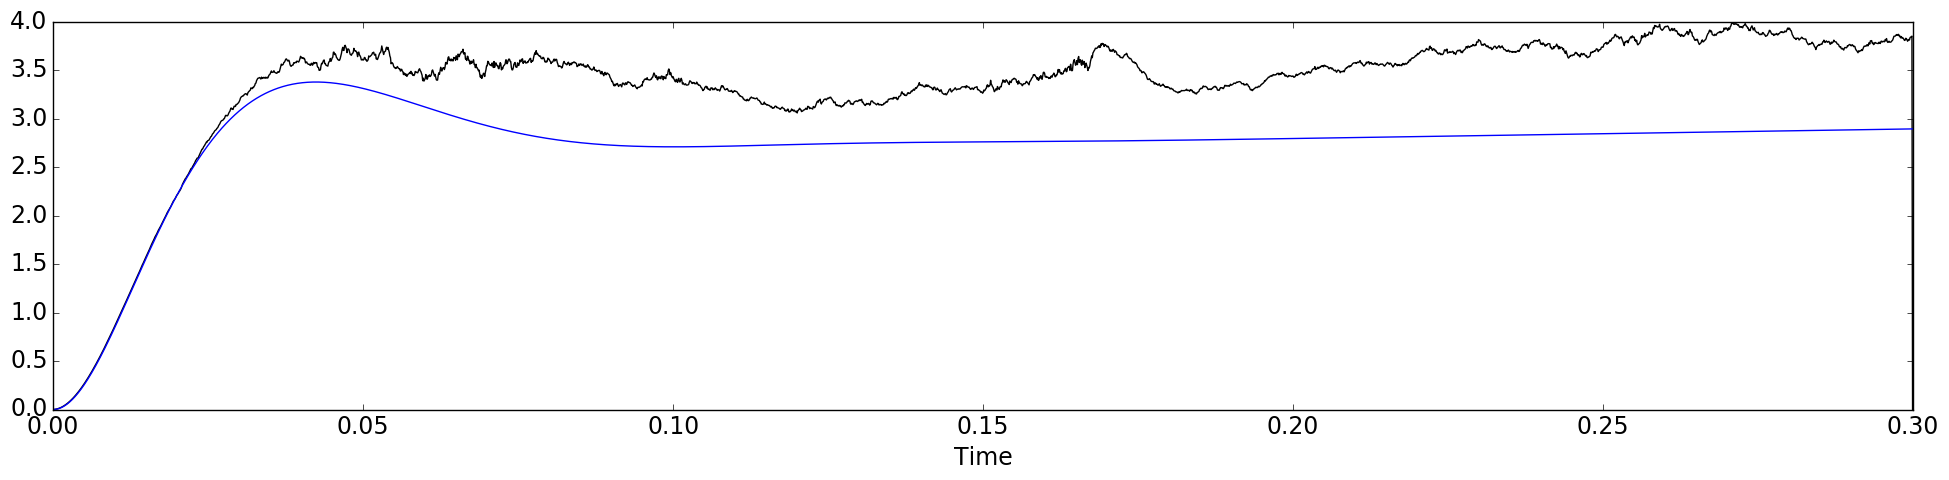

In [24]:
## Comparing Master equation to stochastic SDE

f, a = plt.subplots(figsize=(24,5))
plt.xlabel("Time", fontsize=17);# plt.ylabel("Photon Number", fontsize=17)
plt.tick_params(labelsize=17)

a.plot(tspan,
       np.average( np.asarray( [D['obsq_expects'][t,:,0].real for t in range(ntraj) ] ), axis = 0),
       c='black',
      )
plt.plot(tspan, me_data.expect[0]);

## Save to file

In [48]:
# save2matfile_or_pkl(D, file_name, obs, params = {}, save_mat = save_mat, save_pkl = save_pkl)

# Two systems

In [5]:
from imp import reload

In [6]:
import quantum_state_diffusion 

In [7]:
reload(quantum_state_diffusion)

/Users/gil/anaconda/envs/python_3_env/lib/python3.5/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'quantum_state_diffusion' from '/Users/gil/Google Drive/repos/diffusion_maps/quantum_state_diffusion/quantum_state_diffusion.py'>

In [8]:
I = np.eye(Nfock)

In [9]:
obsq_data_kron = ([sparse.csr_matrix(np.kron(ob.data.todense(), I)) for ob in obsq] 
 + [sparse.csr_matrix(np.kron(I, ob.data.todense())) for ob in obsq])

In [10]:
psi0 = sparse.csr_matrix(([1] + [0]*(Nfock**2-1)),dtype=np.complex128).T
H = H_num.data
Ls = [L.data for L in L_num]
H_no_drive = H_no_drive_num.data
Ls_no_drive = [L.data for L in L_no_drive_num]

obsq_data = [ob.data for ob in obsq]
seed = [i for i in range(ntraj)]

In [11]:
H_null = sparse.csr_matrix(np.zeros(H.shape))

In [12]:
Ls_null = [sparse.csr_matrix(np.zeros(L.shape)) for L in Ls_no_drive]

## Show matrices

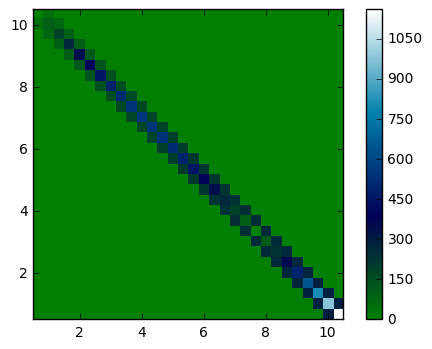

In [21]:
#All the stuff earlier in the program
plt.imshow(abs(H.todense()), interpolation='nearest', cmap=plt.cm.ocean, extent=(0.5,10.5,0.5,10.5))
plt.colorbar()
plt.show()

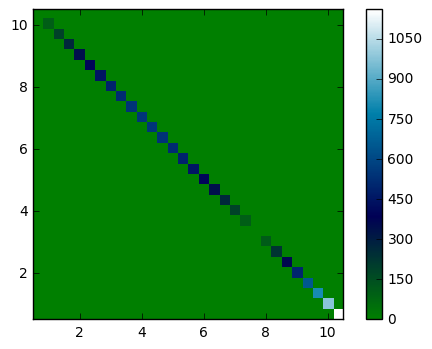

In [22]:
#All the stuff earlier in the program
plt.imshow(abs(H_no_drive.todense()), interpolation='nearest', cmap=plt.cm.ocean, extent=(0.5,10.5,0.5,10.5))
plt.colorbar()
plt.show()

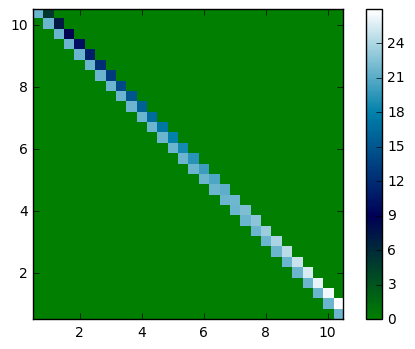

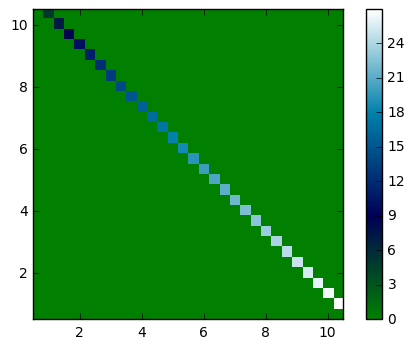

In [23]:
for L in Ls:
    #All the stuff earlier in the program
    plt.imshow(abs(L.todense()), interpolation='nearest', cmap=plt.cm.ocean, extent=(0.5,10.5,0.5,10.5))
    plt.colorbar()
    plt.show()

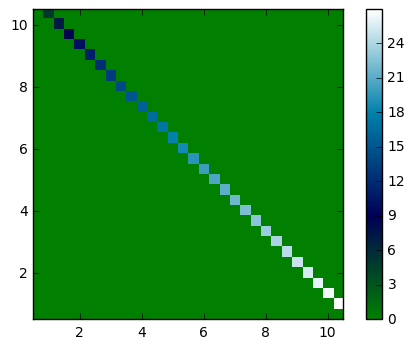

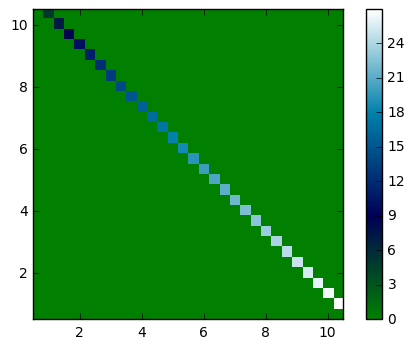

In [24]:
for L in Ls_no_drive:
    #All the stuff earlier in the program
    plt.imshow(abs(L.todense()), interpolation='nearest', cmap=plt.cm.ocean, extent=(0.5,10.5,0.5,10.5))
    plt.colorbar()
    plt.show()

## Pure coherent transmission

In [45]:
D = quantum_state_diffusion. qsd_solve_two_systems(
    H, H_no_drive, psi0, tspan, Ls, Ls_no_drive, 0, 0, 1.,
    sdeint.itoEuler, trans_phase=1.,
    obsq = obsq_data_kron, ntraj = 8, seed = seed[:8], normalize_state = True, downsample=20)
    
N1s = np.concatenate([D['obsq_expects'][t,:,0].real[7500:] for t in range(8)])
N2s = np.concatenate([D['obsq_expects'][t,:,3].real[7500:] for t in range(8)])

done preparing operators...
done running simulation!
Run time:   964.7152121067047  seconds.


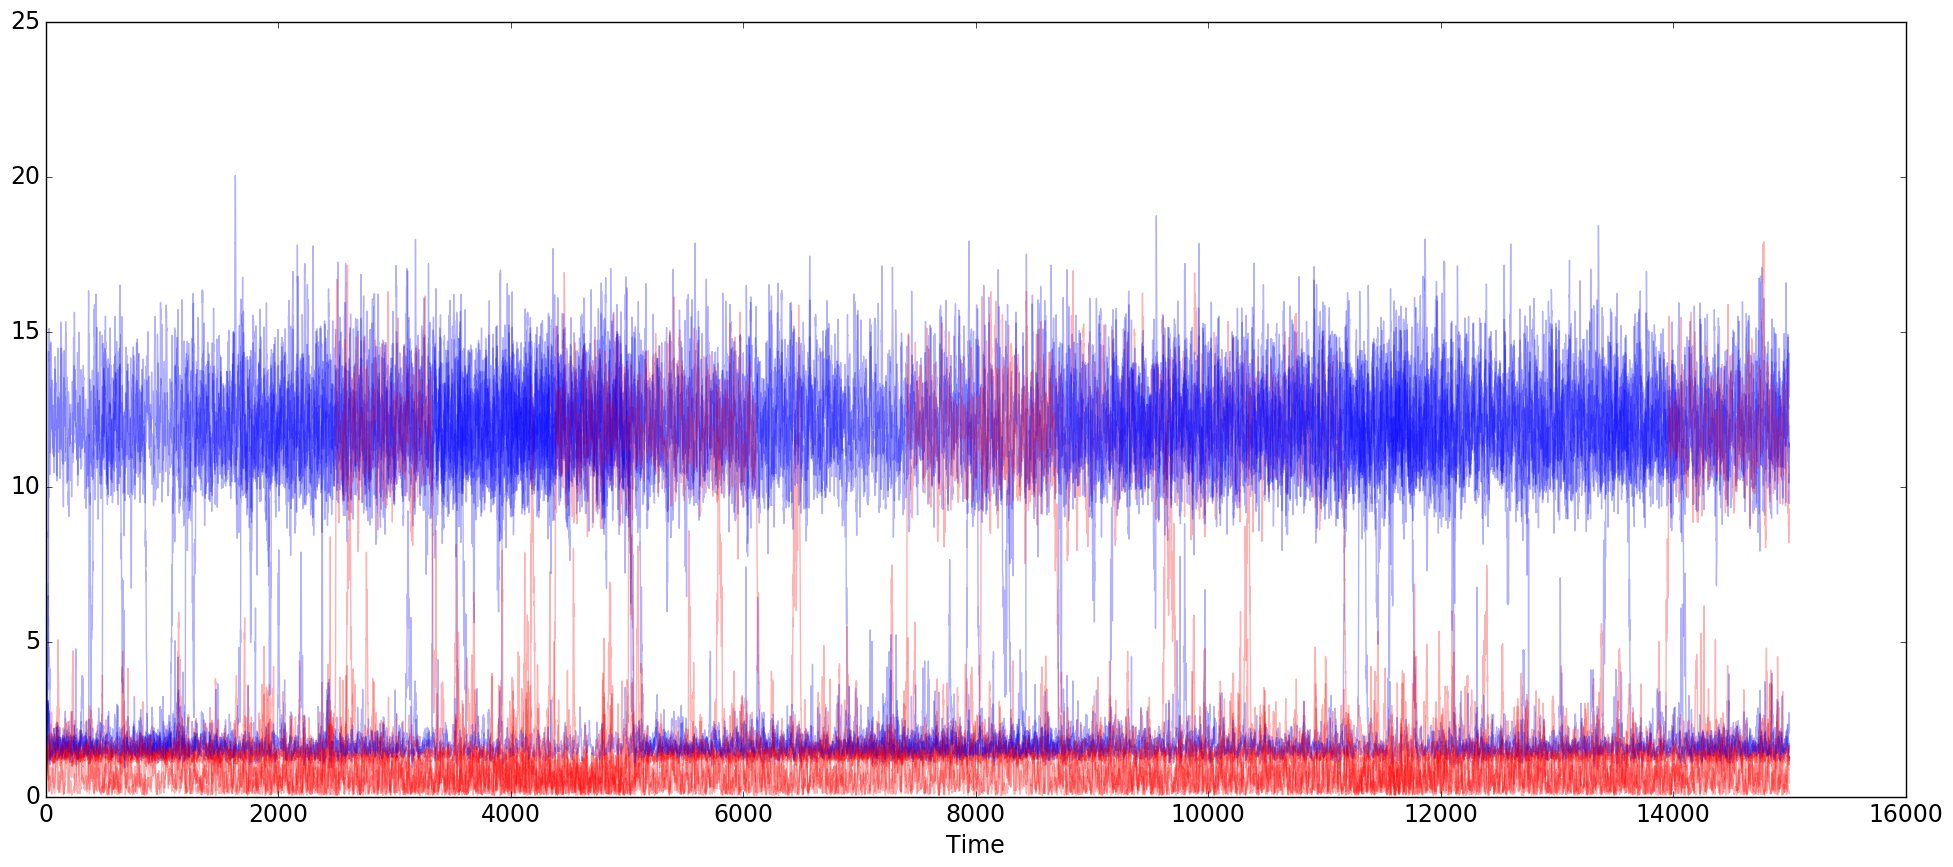

In [46]:
f, a = plt.subplots(figsize=(24,10))
plt.xlabel("Time", fontsize=17);# plt.ylabel("Photon Number", fontsize=17)
plt.tick_params(labelsize=17)

for t in range(8): 
    a.plot( D['obsq_expects'][t,:,0].real , "b", alpha=0.3)
    a.plot( D['obsq_expects'][t,:,3].real , "r", alpha=0.3)

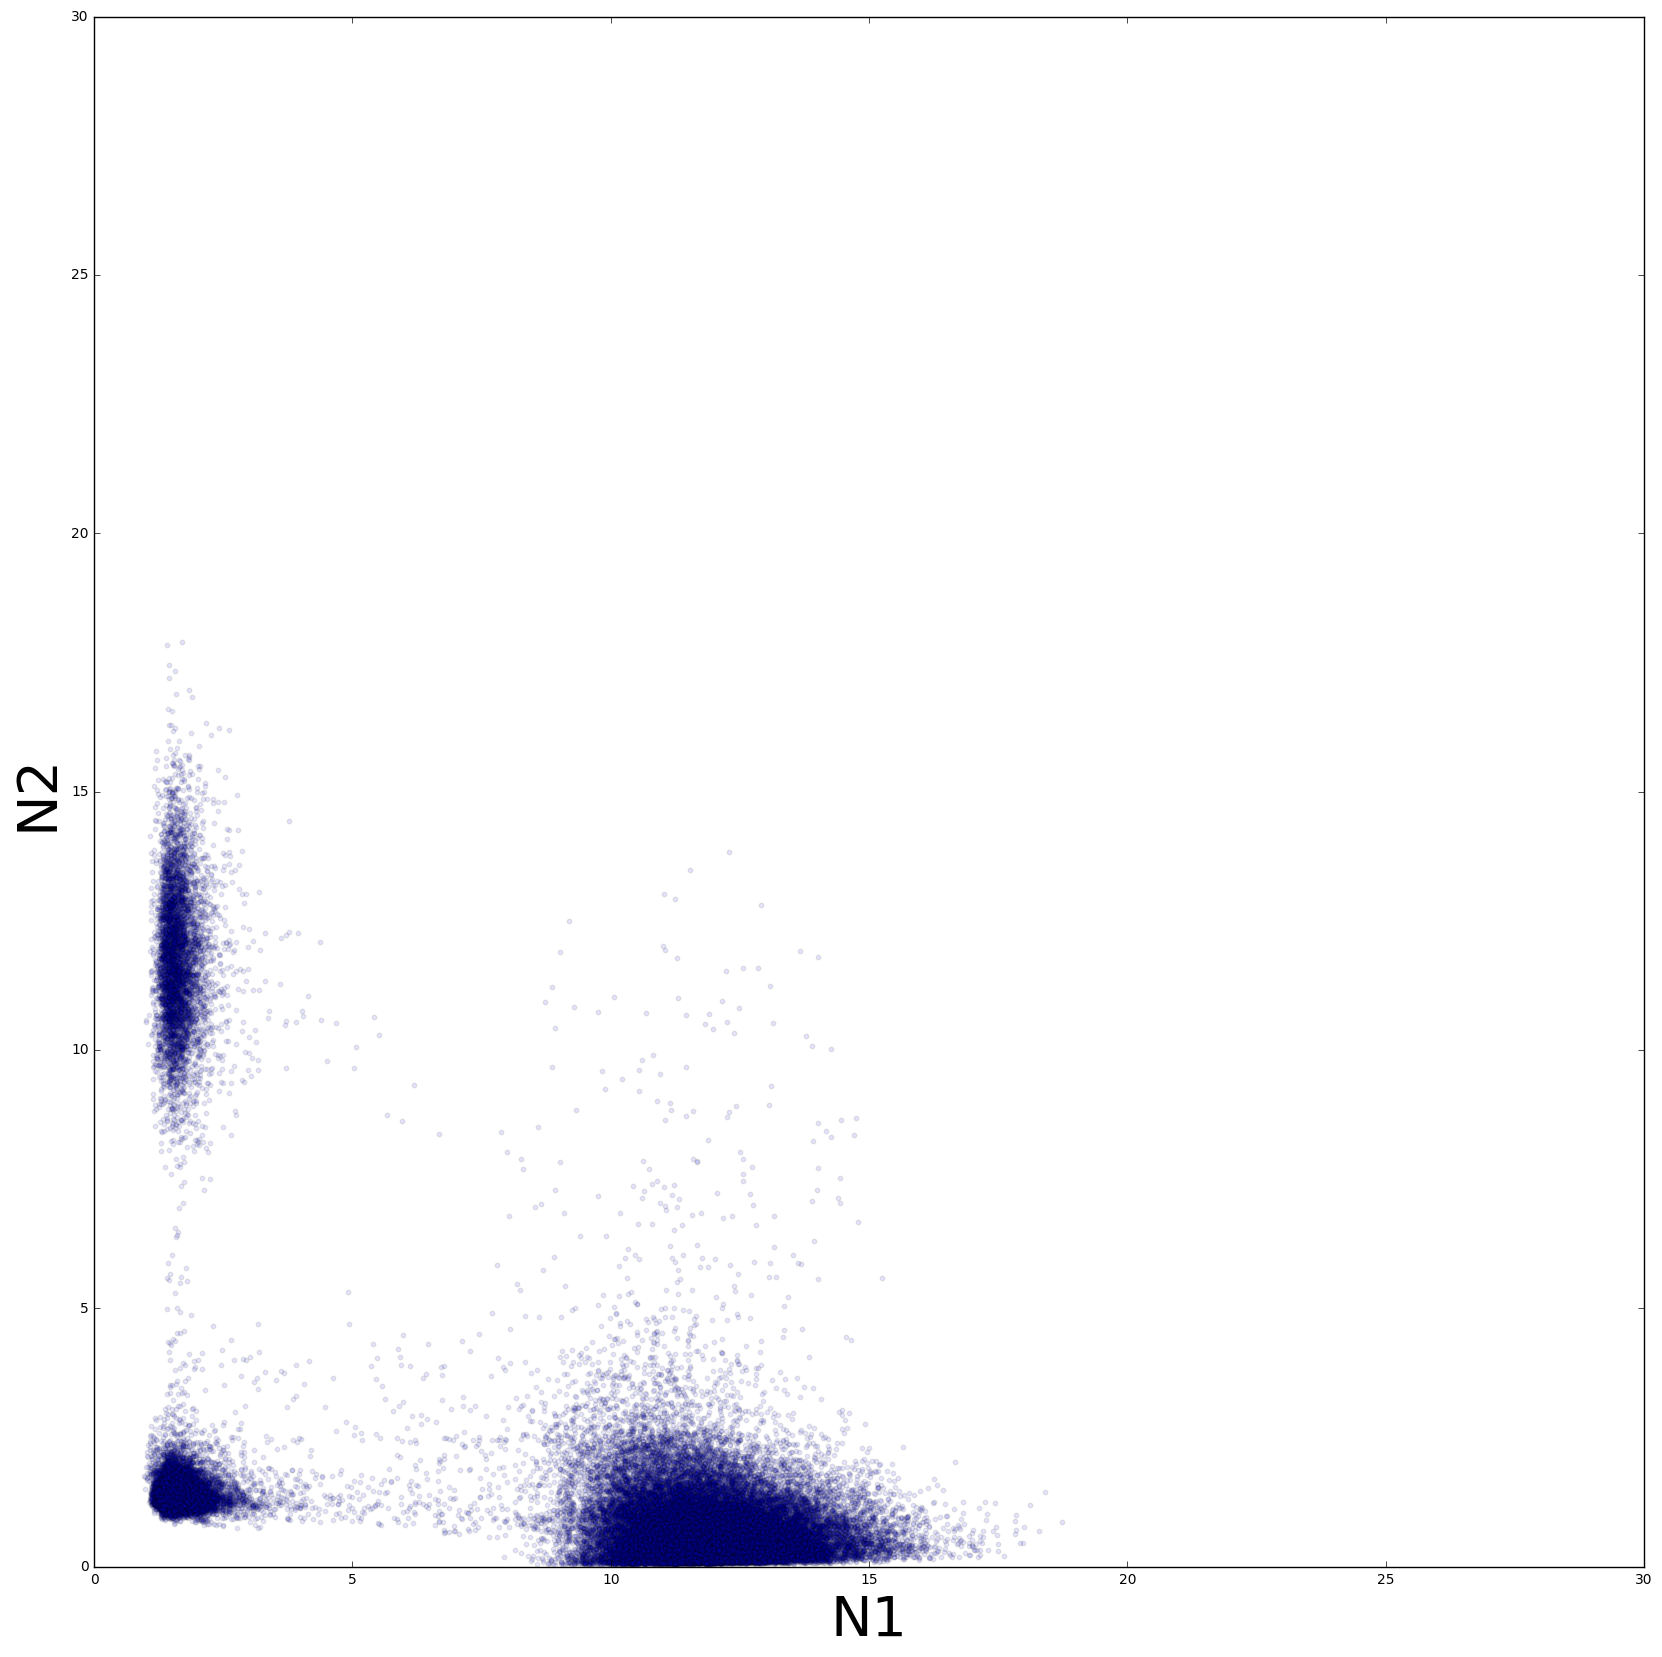

In [47]:
plt.figure(figsize=(20,20))
plt.xlim(0,Nfock)
plt.ylim(0,Nfock)
plt.xlabel('N1', fontsize=40)
plt.ylabel('N2', fontsize=40)
plt.scatter(N1s, N2s, alpha=0.1, s=10)
plt.show()

## Classical transmission, without measurement feedback noise

In [48]:
D = quantum_state_diffusion. qsd_solve_two_systems(
    H, H_no_drive, psi0, tspan, Ls, Ls_no_drive, 1., 1., 0.,
    sdeint.itoEuler, trans_phase=1.,
    obsq = obsq_data_kron, ntraj = 8, seed = seed[:8], normalize_state = True, downsample=20)
    
N1s = np.concatenate([D['obsq_expects'][t,:,0].real[7500:] for t in range(8)])
N2s = np.concatenate([D['obsq_expects'][t,:,3].real[7500:] for t in range(8)])

done preparing operators...
done running simulation!
Run time:   963.2392220497131  seconds.


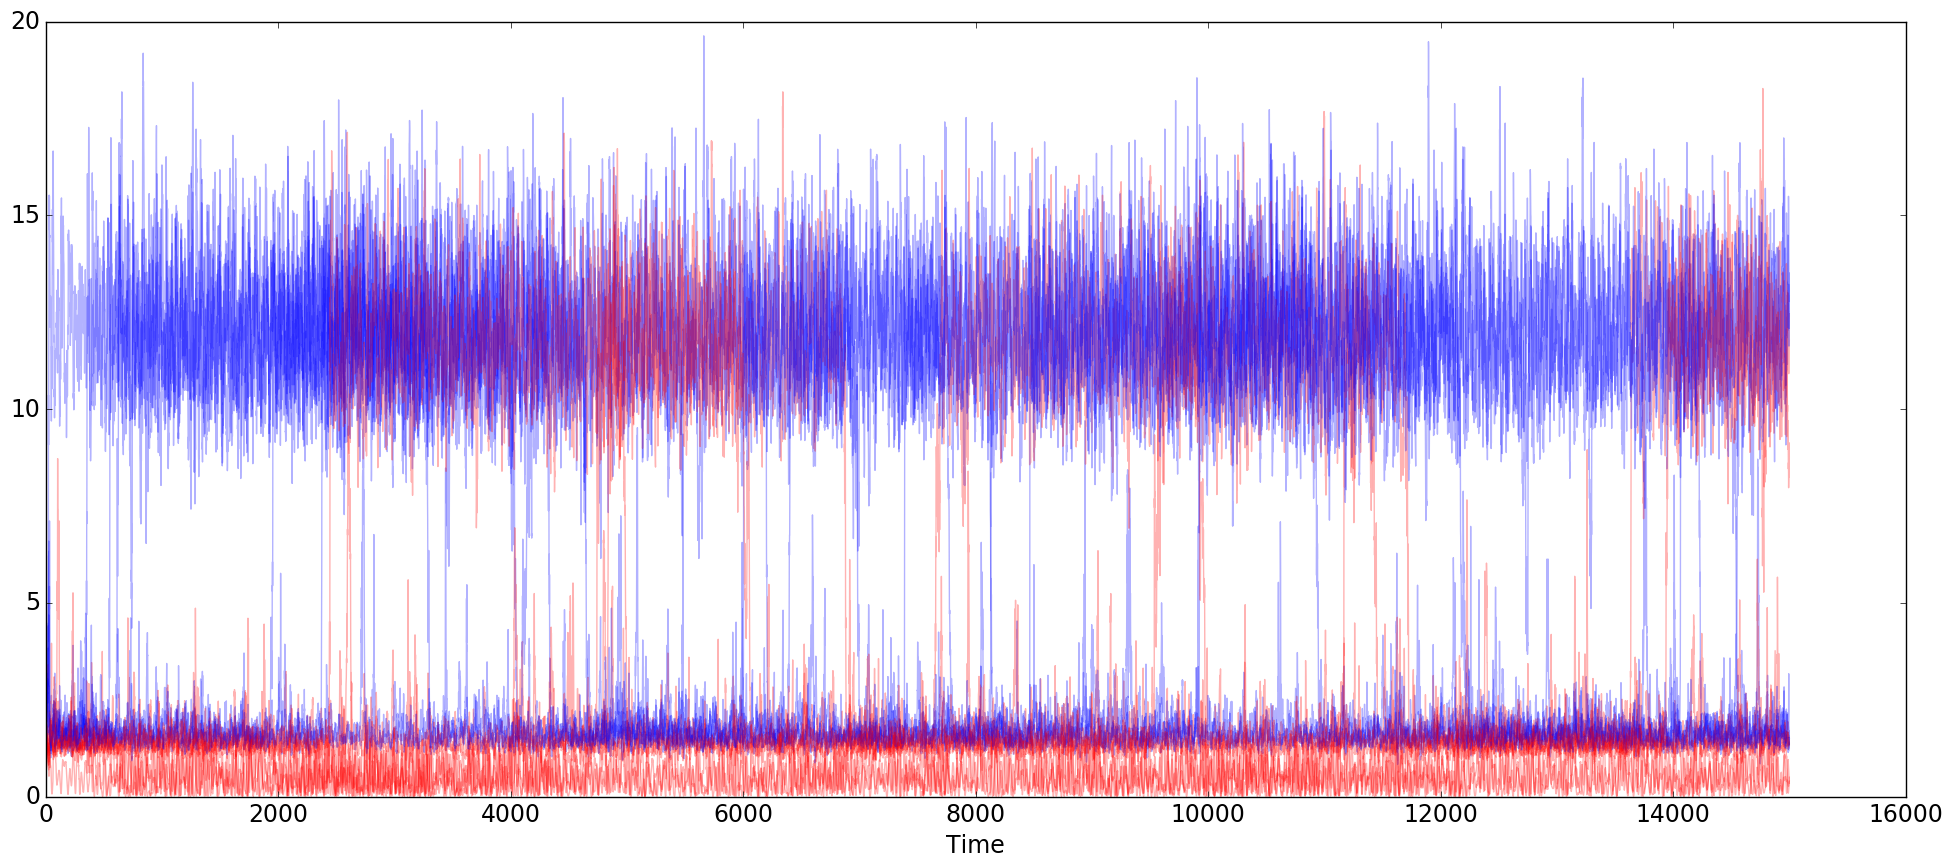

In [49]:
f, a = plt.subplots(figsize=(24,10))
plt.xlabel("Time", fontsize=17);# plt.ylabel("Photon Number", fontsize=17)
plt.tick_params(labelsize=17)

for t in range(8): 
    a.plot( D['obsq_expects'][t,:,0].real , "b", alpha=0.3)
    a.plot( D['obsq_expects'][t,:,3].real , "r", alpha=0.3)

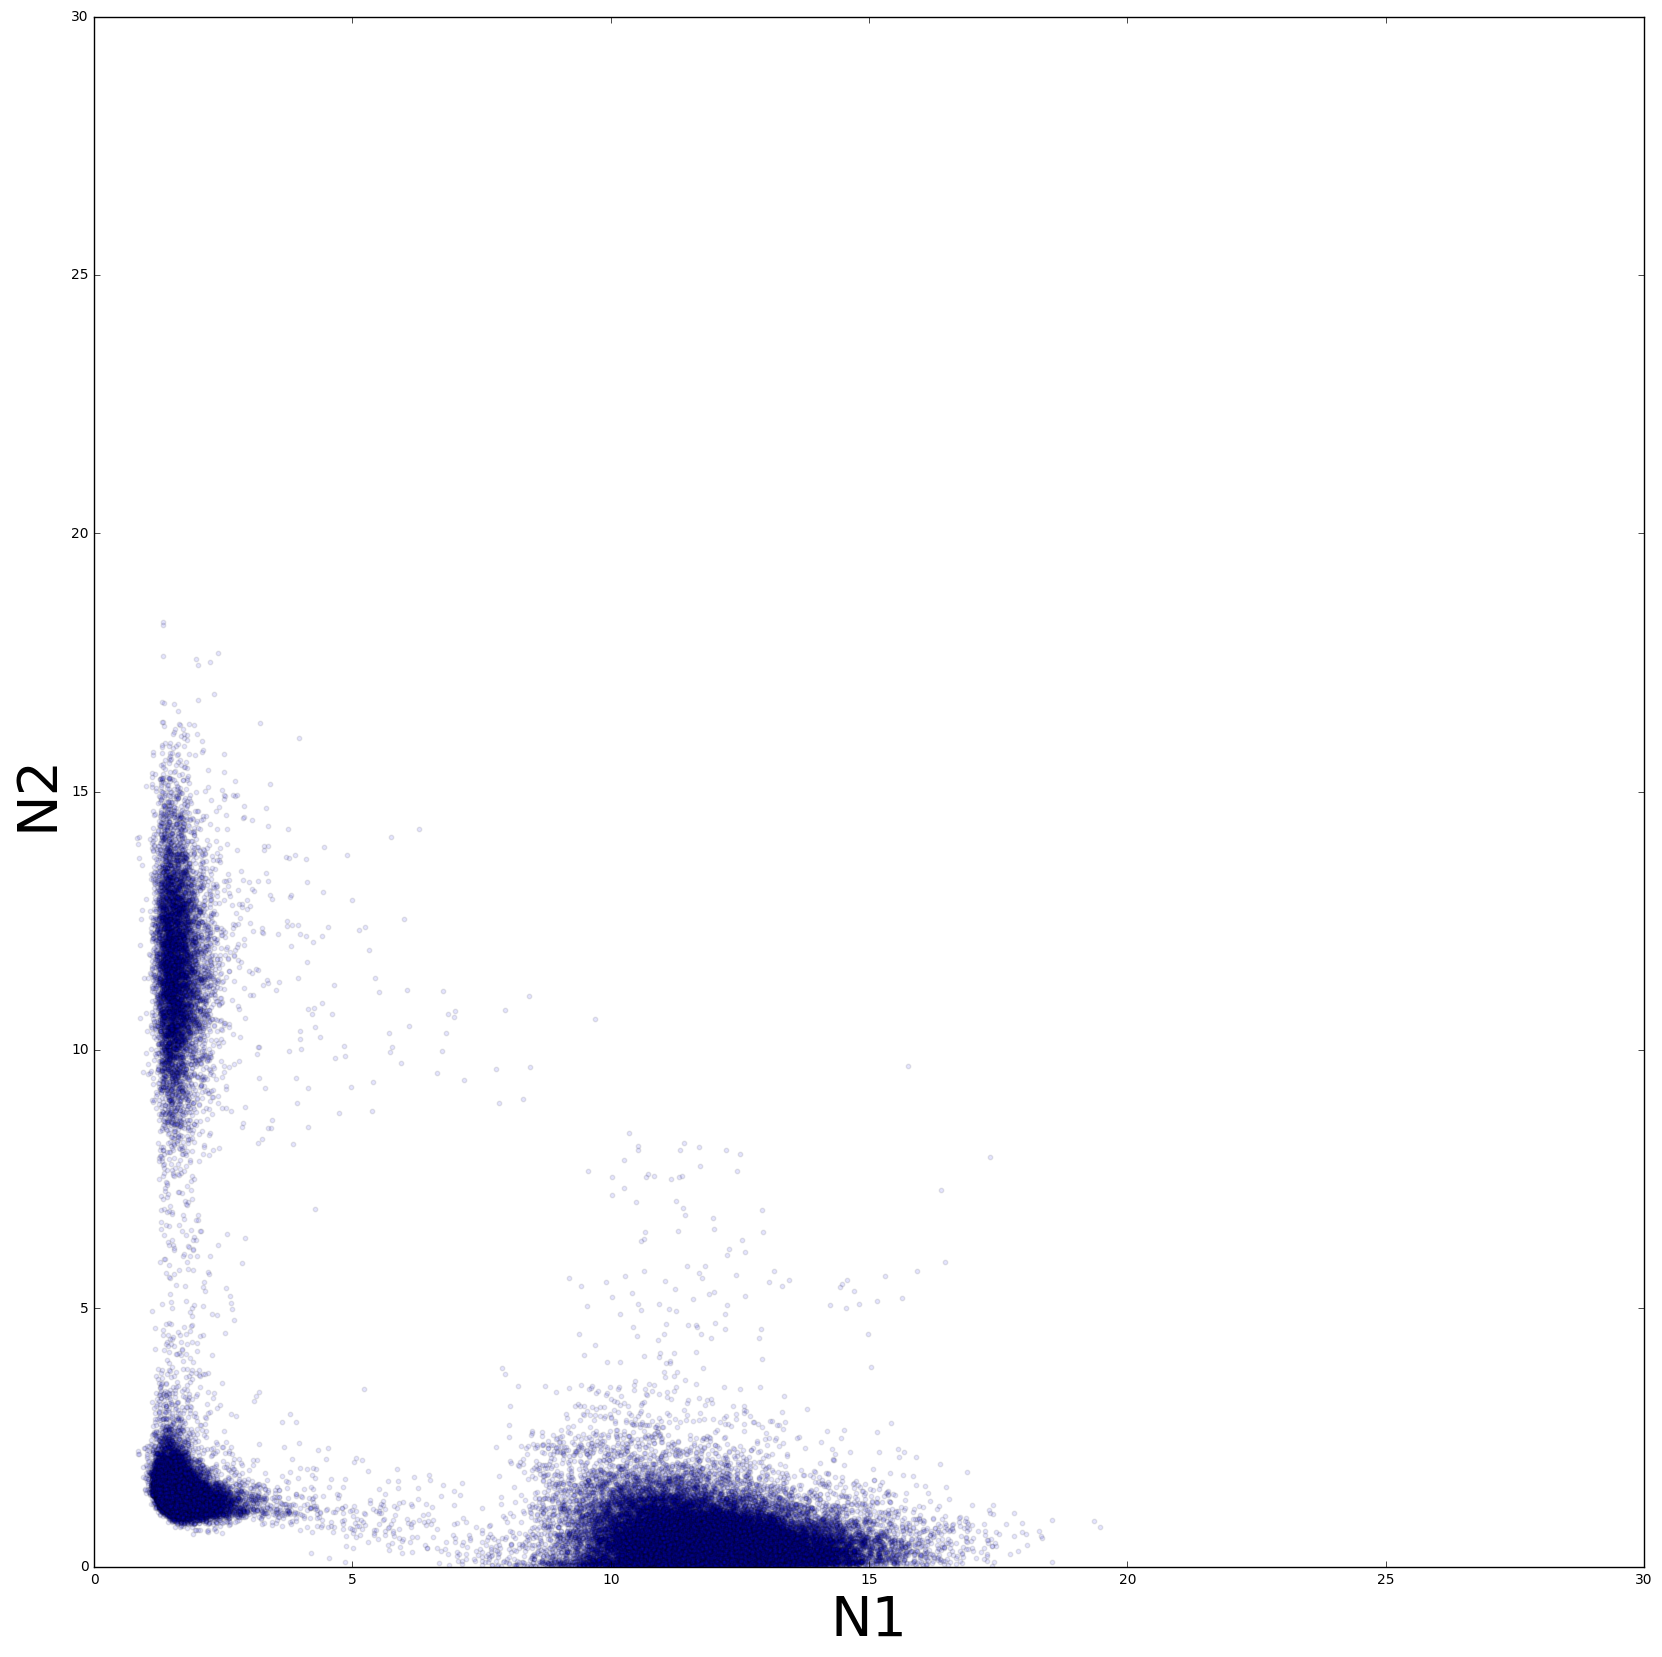

In [50]:
plt.figure(figsize=(20,20))
plt.xlim(0,Nfock)
plt.ylim(0,Nfock)
plt.xlabel('N1', fontsize=40)
plt.ylabel('N2', fontsize=40)
plt.scatter(N1s, N2s, alpha=0.1, s=10)
plt.show()

## Classical transmission, with measurement feedback noise

In [13]:
R = 1.
eps = 1.

In [1]:
for n in [0.3, 0.5, 0.7, 0.8, 0.9]:
    D = quantum_state_diffusion. qsd_solve_two_systems(
        H, H_no_drive, psi0, tspan, Ls, Ls_no_drive, R, eps, n,
        sdeint.itoEuler, trans_phase=1.,
        obsq = obsq_data_kron, ntraj = 8, seed = seed[:8], normalize_state = True, downsample=100)

    N1s = np.concatenate([D['obsq_expects'][t,:,0].real for t in range(8)])
    N2s = np.concatenate([D['obsq_expects'][t,:,3].real for t in range(8)])

    f, a = plt.subplots(figsize=(24,10))
    plt.xlabel("Time", fontsize=17);# plt.ylabel("Photon Number", fontsize=17)
    plt.tick_params(labelsize=17)

    for t in range(8): 
        a.plot( D['obsq_expects'][t,:,0].real , "b", alpha=0.3)
        a.plot( D['obsq_expects'][t,:,3].real , "r", alpha=0.3)
    plt.show()
    
    plt.figure(figsize=(20,20))
    plt.xlim(0,Nfock)
    plt.ylim(0,Nfock)
    plt.xlabel('N1', fontsize=40)
    plt.ylabel('N2', fontsize=40)
    plt.scatter(N1s, N2s, alpha=0.1, s=10)
    plt.show()

## Classical transmission with null system 2

In [18]:
D = quantum_state_diffusion. qsd_solve_two_systems(
    H, H_null, psi0, tspan, Ls, Ls_null, 1., 1., 1.,
    sdeint.itoEuler, trans_phase=1.,
    obsq = obsq_data_kron, ntraj = 8, seed = seed[:8], normalize_state = True, downsample=20)
    
N1s = np.concatenate([D['obsq_expects'][t,:,0].real[7500:] for t in range(8)])
N2s = np.concatenate([D['obsq_expects'][t,:,3].real[7500:] for t in range(8)])

done preparing operators...
done running simulation!
Run time:   824.8098239898682  seconds.


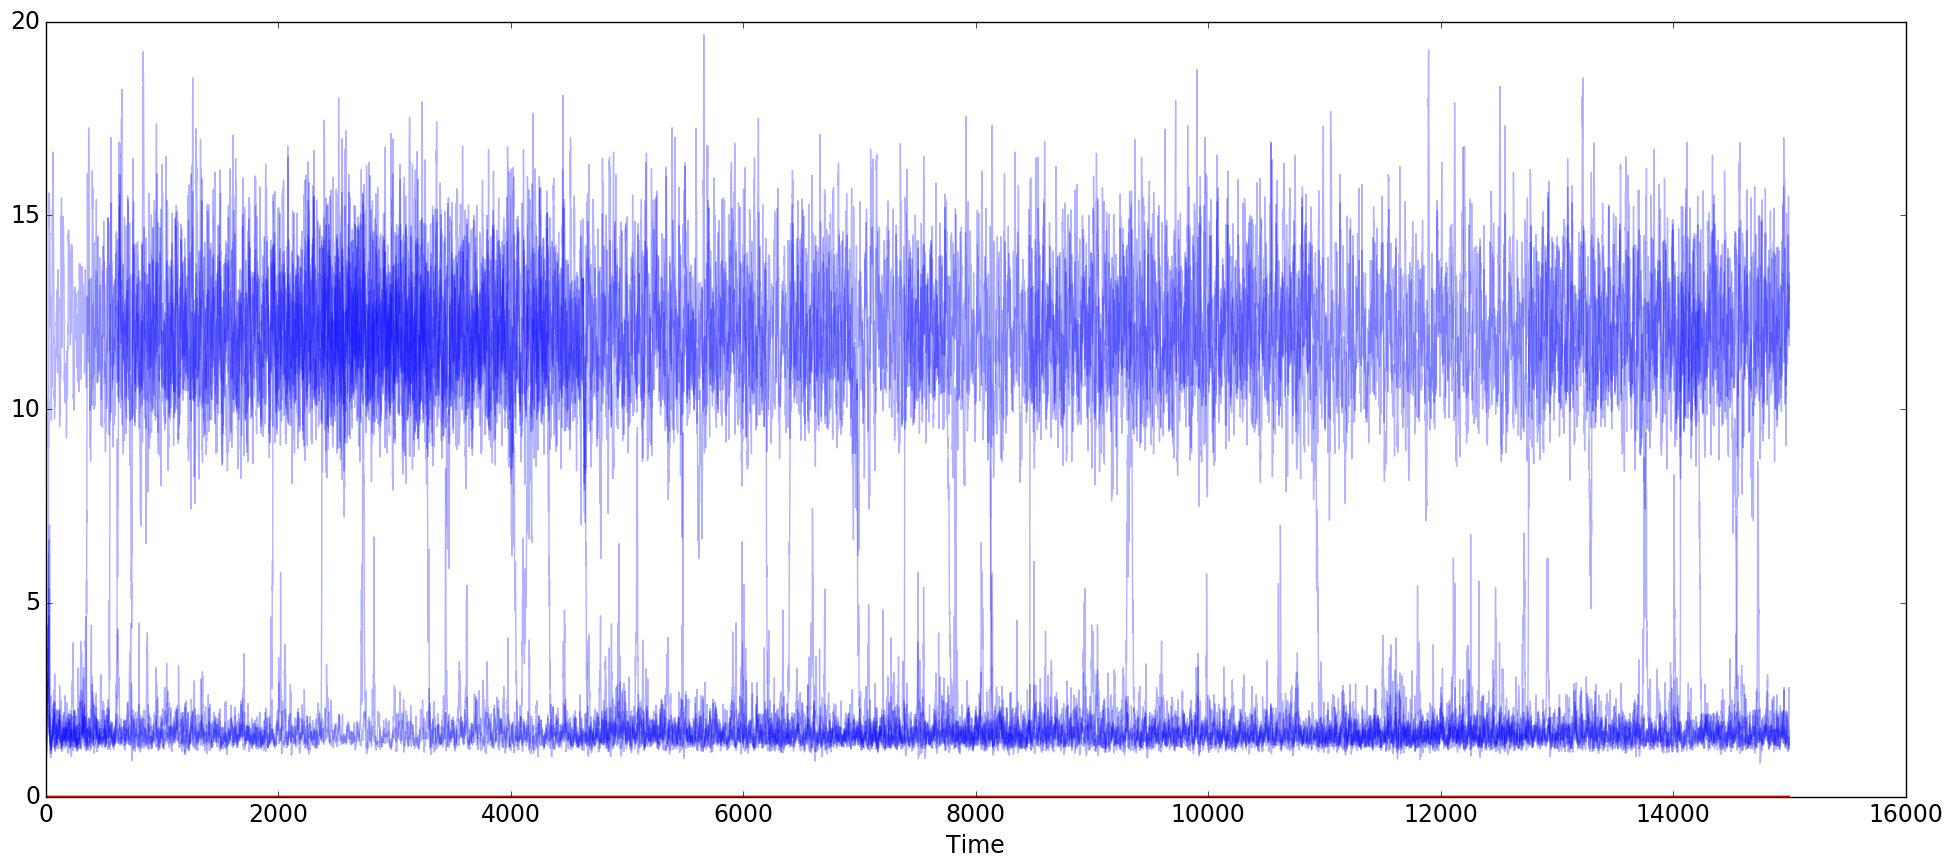

In [19]:
f, a = plt.subplots(figsize=(24,10))
plt.xlabel("Time", fontsize=17);# plt.ylabel("Photon Number", fontsize=17)
plt.tick_params(labelsize=17)

for t in range(8): 
    a.plot( D['obsq_expects'][t,:,0].real , "b", alpha=0.3)
    a.plot( D['obsq_expects'][t,:,3].real , "r", alpha=0.3)

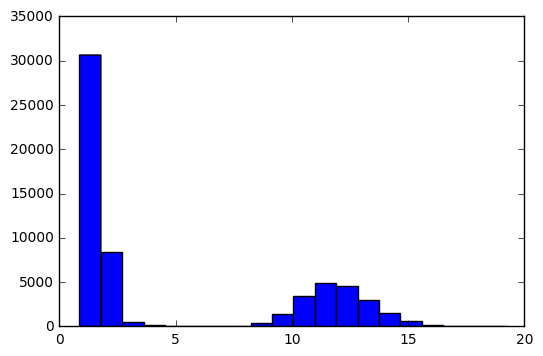

In [23]:
plt.hist(N1s, bins=20);

## Experiments with different values for $r$ and $\epsilon$ below

In [30]:
obs_dict = {}
for r in np.linspace(1./4,1,4):
    if r == 0:
        eps = 0
    else:
        eps = (1 - np.sqrt(1-r**2))/r
    D = quantum_state_diffusion. qsd_solve_two_systems(
        H, H_no_drive, psi0, tspan, Ls, Ls_no_drive, r, eps, 1., sdeint.itoEuler,
        trans_phase=-1., obsq = obsq_data_kron, ntraj = 8,
        seed = seed[:8], normalize_state = True, downsample=20)
    obs_dict[r] = D['obsq_expects']

done preparing operators...
done running simulation!
Run time:   933.4425110816956  seconds.
done preparing operators...
done running simulation!
Run time:   947.3478240966797  seconds.
done preparing operators...
done running simulation!
Run time:   969.855094909668  seconds.
done preparing operators...
done running simulation!
Run time:   957.537525177002  seconds.


In [39]:
for r in np.linspace(1./4,1,4):
    print (r, (1 - np.sqrt(1-r**2))/r)

0.25 0.127016653793
0.5 0.267949192431
0.75 0.451416229645
1.0 1.0


In [ ]:
import sys
sum(sys.getsizeof(i) for i in obs_dict.values())

In [ ]:
for r in np.linspace(1./4,1,4):
    N1s = np.concatenate([obs_dict[r][t,:,0].real[7500:] for t in range(8)])
    N2s = np.concatenate([obs_dict[r][t,:,3].real[7500:] for t in range(8)])
    plt.figure(figsize=(20,20))
    plt.xlim(0,30)
    plt.ylim(0,30)
    plt.xlabel('N1', fontsize=40)
    plt.ylabel('N2', fontsize=40)
    plt.scatter(N1s, N2s, alpha=0.1, s=10)
    plt.show()

# Kerr Qubit Regime

In [67]:
Regime = "kerr_qubit"
file_name = '.' + directory_name + '/QSD_' + Regime

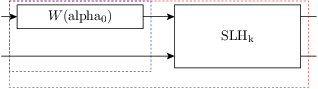

In [92]:
# Define Kerr parameters
chi = symbols("chi", real=True, positive=True)
Delta = symbols("Delta", real=True)
kappa_1, kappa_2 = symbols("kappa_1, kappa_2", real=True, positive=True)
alpha0 = symbols("alpha_0")

## qubit regime
params = {alpha0 : 10.0, chi : -100, Delta : 0., kappa_1 : 0.5, kappa_2 : 0,
          'Ntraj' : 10, 'duration' : 1500., 'Nfock' : 15, 'delta_t': 1e-5, 'downsample': 100}

## These are used later in the simulation
ntraj = params['Ntraj']
duration = params['duration']
Nfock = params['Nfock']
delta_t = params['delta_t']
downsample = params['downsample']

# Construct Kerr SLH
a_k = Destroy("k")
S = -identity_matrix(2)
L = [sqrt(kappa_1)*a_k, sqrt(kappa_2)*a_k]
H = Delta*a_k.dag()*a_k + chi/2*a_k.dag()*a_k.dag()*a_k*a_k
KERR = SLH(S, L, H).toSLH()

# Add coherent drive
SYS = KERR << Displace(alpha=alpha0)+cid(1)
SYS.show()
SYS = SYS.toSLH()

SYS_num = SYS.substitute(params)

SYS_num.space.dimension = Nfock
tspan = np.arange(0, duration*1e-3, delta_t)

H_num, L_num = SYS_num.HL_to_qutip()

## Observables

obs = [a_k.dag()*a_k, a_k+a_k.dag(), (a_k-a_k.dag())/1j]
obsq = [o.to_qutip(full_space = SYS_num.space) for o in obs]

In [93]:
psi0 = sparse.csr_matrix(([1] + [0]*(Nfock-1)),dtype=np.complex128).T
H = H_num.data
Ls = [L.data for L in L_num]
obsq = [ob.data for ob in obsq]

In [94]:
seed = [i for i in range(ntraj)]

In [95]:
D = qsd_solve(H, psi0, tspan, Ls, sdeint.itoSRI2, obsq = obsq, ntraj = ntraj, seed = seed, normalize_state = True)

Run time:   372.822350025177  seconds.


In [96]:
D.update({'tspan':tspan})
D_downsampled = {'psis' : D['psis'][:,::downsample],
                 'obsq_expects' : D['obsq_expects'][:,::downsample], 
                 'seeds' : D['seeds'],
                 'tspan' : D['tspan'] }

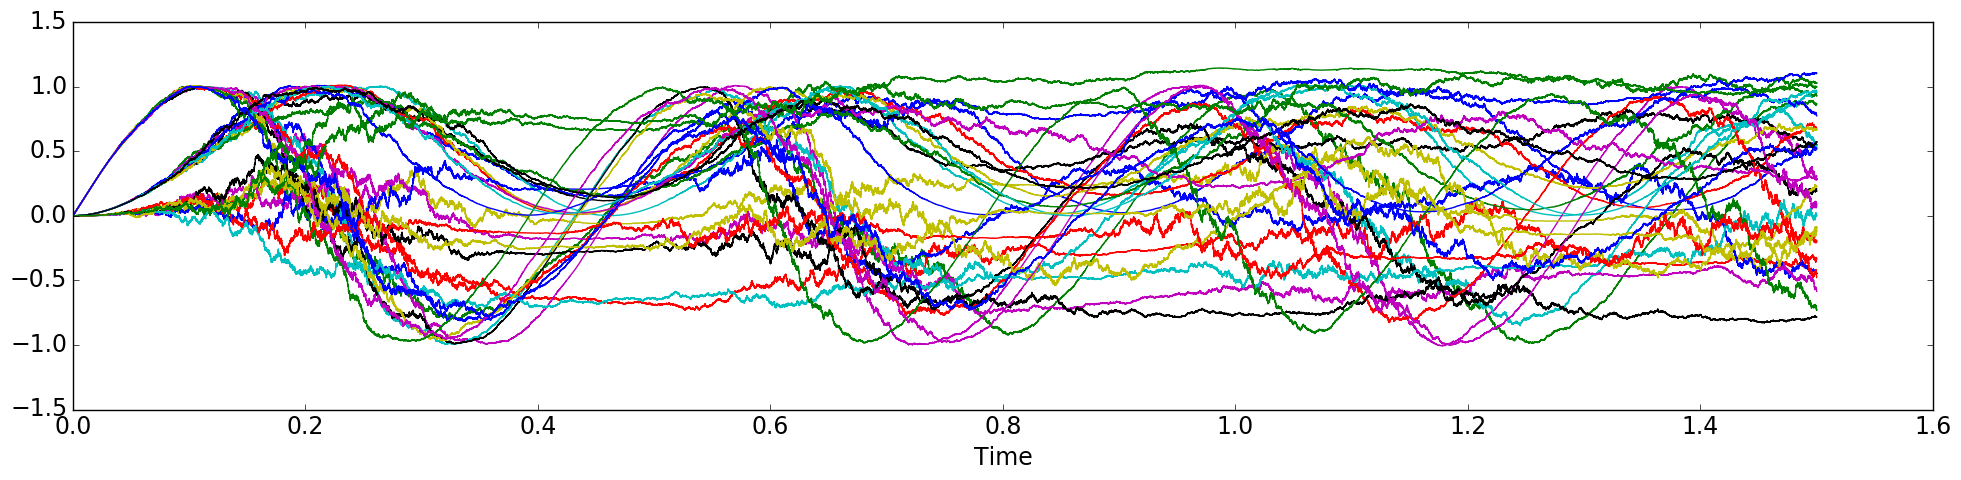

In [97]:
## Plot the observables
f, a = plt.subplots(figsize=(24,5))
plt.xlabel("Time", fontsize=17);# plt.ylabel("Photon Number", fontsize=17)
plt.tick_params(labelsize=17)

for t in range(ntraj):
    for i in range(3):
        plt.plot(tspan,D['obsq_expects'][t,:,i].real)

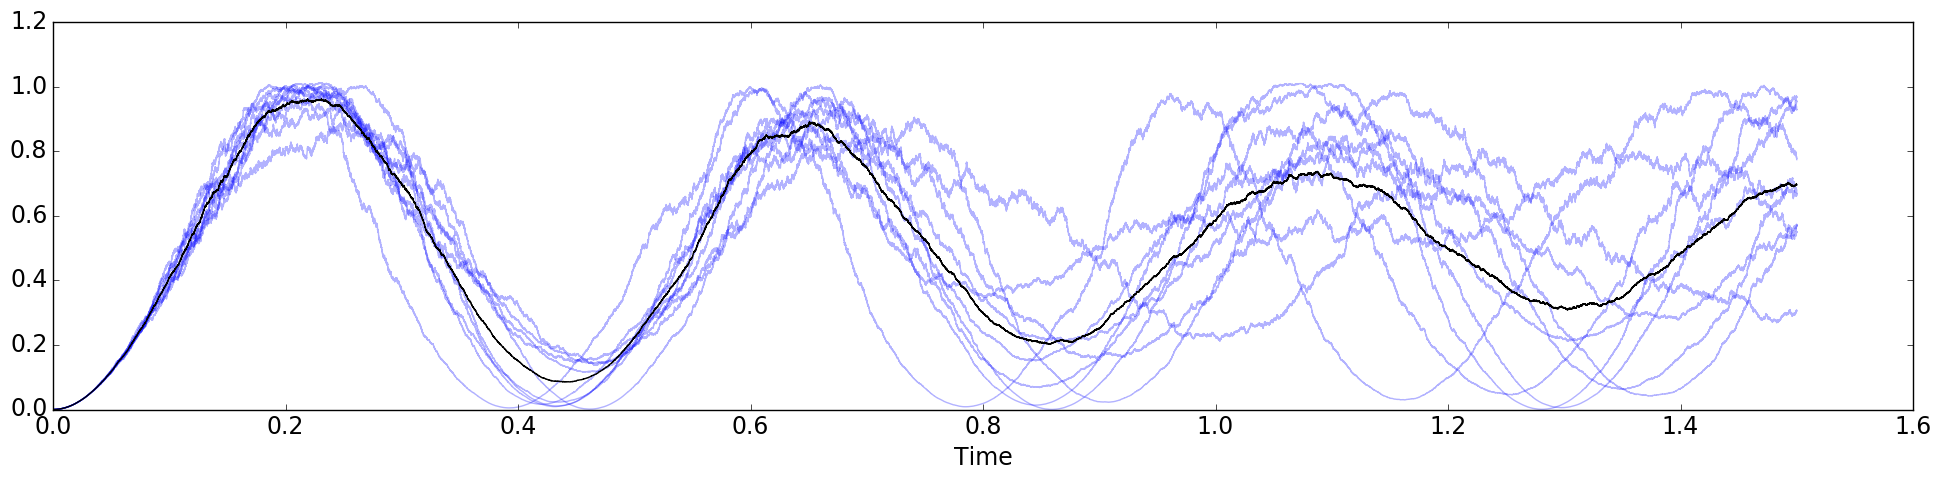

In [98]:
f, a = plt.subplots(figsize=(24,5))
plt.xlabel("Time", fontsize=17);# plt.ylabel("Photon Number", fontsize=17)
plt.tick_params(labelsize=17)


for t in range(ntraj): 
    a.plot( tspan, D['obsq_expects'][t,:,0].real , "b", alpha=0.3)

a.plot(tspan,
       np.average( np.asarray( [D['obsq_expects'][t,:,0].real for t in range(ntraj) ] ), axis = 0),
       c='black',
      )


## Save to file...

In [49]:
# save2matfile_or_pkl(D_downsampled, file_name, obs, params = {}, save_mat = save_mat, save_pkl = save_pkl)